In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

import csv

import requests

from functions import *
from tqdm import tqdm


# API call

In [2]:
# https://ssd-api.jpl.nasa.gov/doc/horizons.html

url = "https://ssd.jpl.nasa.gov/api/horizons.api"
format = "format=text"
command = "COMMAND=" # target body
targets = ["10", "199", "299", "399", "301", "499", "599", "699", "799", "899"]  # sun, mercury, venus, earth, moon, mars, jupiter, saturn, uranus, neptun
target_names = ["sun", "mercury", "venus", "earth", "moon", "mars", "jupiter", "saturn", "uranus", "neptun"]
obj_data = "OBJ_DATA='NO'"
ephemeris = "MAKE_EPHEM='YES'"
eph_type = "EPHEM_TYPE='VECTORS'"
vec_table = "VEC_TABLE='2'"
center = "CENTER='500@0'"
start = "START_TIME='1800-01-01'"
stop = "STOP_TIME='2023-01-01'"
step = "STEP_SIZE='1 y'"
cal_type = "CAL_TYPE=GREGORIAN"
vector_labels = "VEC_LABELS=NO"
csv_format = "CSV_FORMAT=YES"
units = "OUT_UNITS='AU-D'"
#quantities = "QUANTITIES='1,9,20,23,24,29'"

In [3]:
data = []
time = []
for target in targets:
    path = url+"?"+format+"&"+command+target+"&"+obj_data+"&"+ephemeris+"&"+eph_type+"&"+vec_table+"&"+center+"&"+start+"&"+stop+"&"+step+"&"+cal_type+"&"+vector_labels+"&"+csv_format+"&"+units
    q, p, t = read_data(requests.get(path).text)
    data.append([[q], [p]])
    time.append([t])
    
data = np.asarray(data).reshape((len(targets),2,len(data[0][0][0]),3))
time = np.asarray(time).reshape((len(targets),len(time[0][0])))

In [4]:
print(data.shape)

(10, 2, 224, 3)


## Data shape

10 x target body <br>
2 x vectors - q & p <br>
n x data points <br>
3 x coordinates - x, y, z

# Phase spaces for all bodies in the system

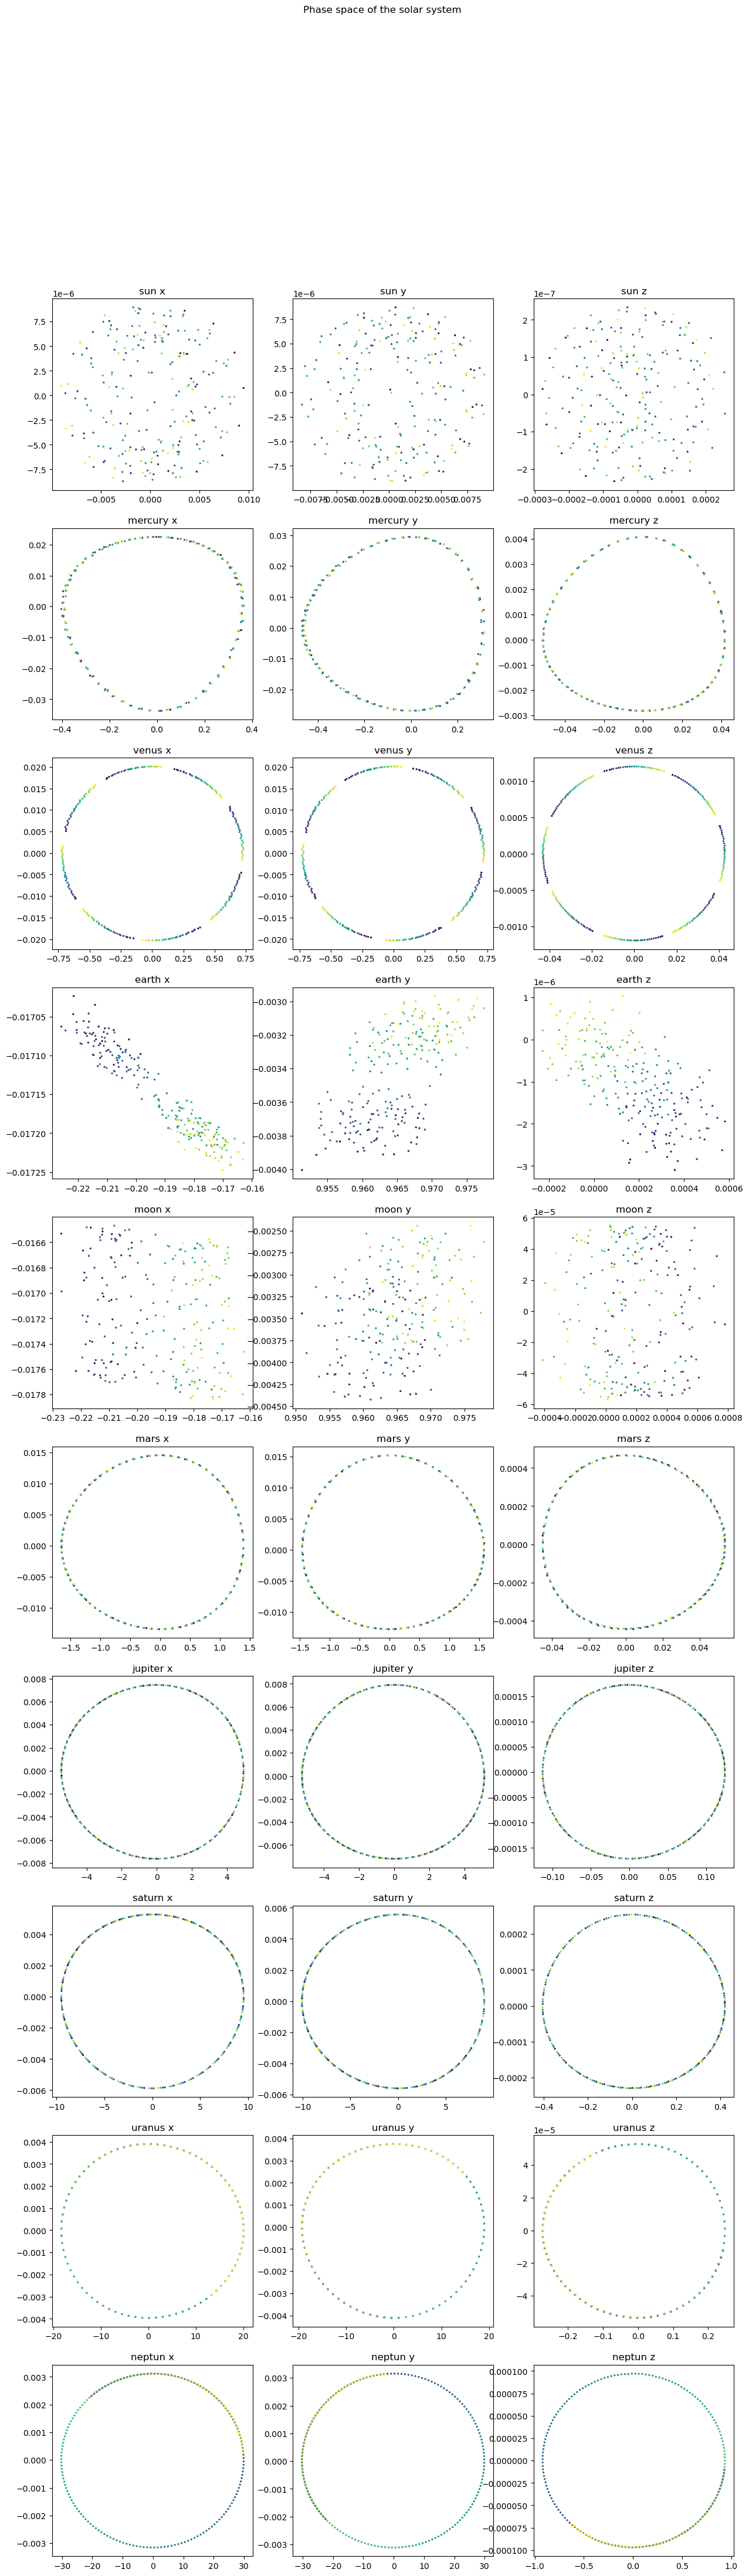

In [5]:
plot_phase_space(data, target_names, "Phase space of the solar system")

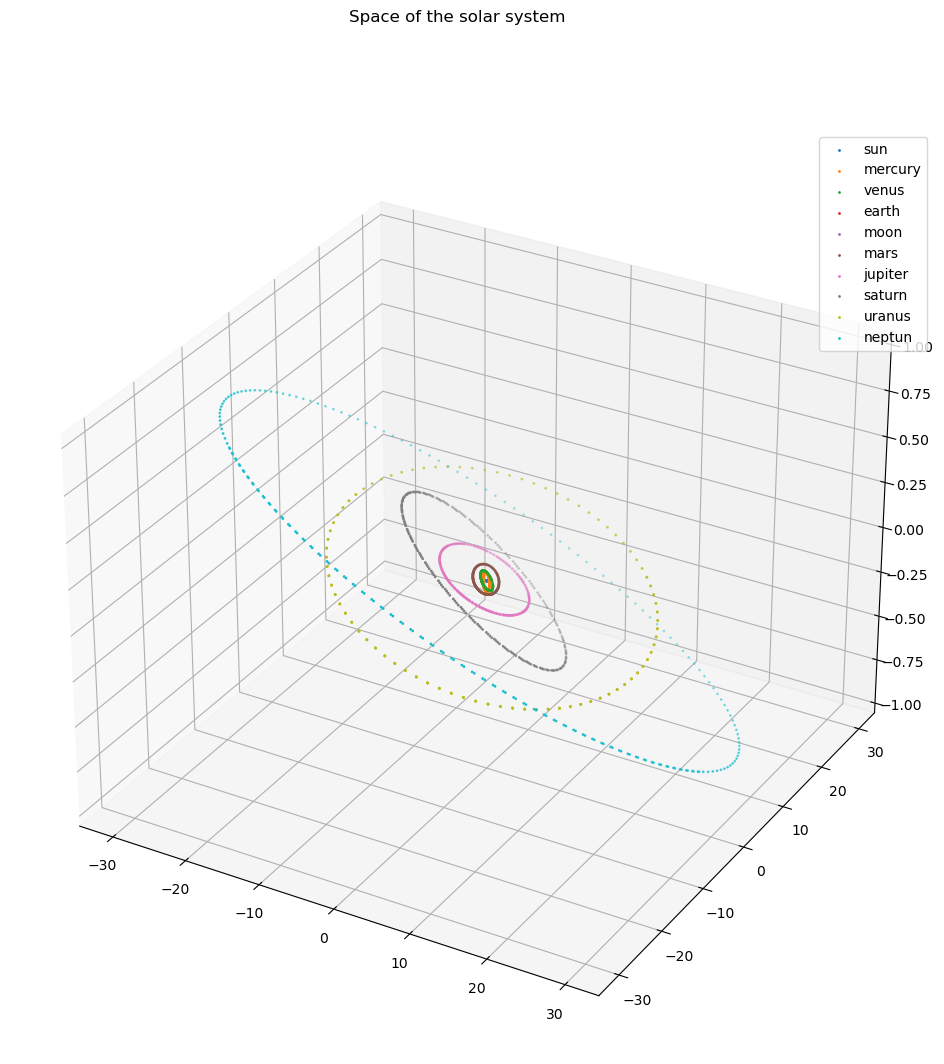

In [6]:
plot_space(data, target_names, "Space of the solar system")

# Learning the solar system

## Preparing the data

In [7]:
nep_x = np.array([data[9][0].T[0], data[9][1].T[0]])
nep_dx = np.diff(nep_x, axis=1) / 365

nep_x = torch.tensor(nep_x.T[0:-1], dtype=torch.float32, requires_grad=True)
nep_dx = torch.tensor(nep_dx.T, dtype=torch.float32, requires_grad=True)

#q, dq, p, dp = prep_data(nep_x, time)

## Normal Neural Network

In [8]:
class MLP(nn.Module):
    def __init__(self, bodys) -> None:
        super().__init__()

        self.fc1 = nn.Linear(bodys, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 200)
        self.fc4 = nn.Linear(200, bodys)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

## Hamiltonian

## Training loop

In [9]:
def train(model, x, dx, batch_size=32, epochs=100, baseline=True, lr=0.001):
    loss_hist = []

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = nn.MSELoss()

    for step in tqdm(range(epochs+1)):
        model.train()
        for batch in range(0, len(x), batch_size):
            x_batch = x[batch:batch+batch_size]
            dx_batch = dx[batch:batch+batch_size]

            """x_batch = x_batch - x_batch.T.min(1)[0]
            x_batch = x_batch / x_batch.T.max(1)[0]

            dx_batch = dx_batch - dx_batch.T.min(1)[0]
            dx_batch = dx_batch / dx_batch.T.max(1)[0]"""

            optimizer.zero_grad()

            if baseline:
                pred = model(x_batch)
            else:   
                pred = HNN(x_batch, model)

            loss_val = loss(pred, dx_batch)
            loss_val.backward()
            optimizer.step()

        if step % (epochs/10) == 0:
            model.eval()
            if baseline:
                pred = model(x)
            else:   
                pred = HNN(x, model)

            loss_val = loss(pred, dx)
            loss_hist.append(loss_val.item())
            
            #print(f"Epoch {step}/{epochs} --- Train-Loss: {loss_val.item()}")#{round(loss_val.item(), 3)}")

    plt.plot(loss_hist)

# Baseline NN

100%|██████████| 21/21 [00:02<00:00,  7.36it/s]


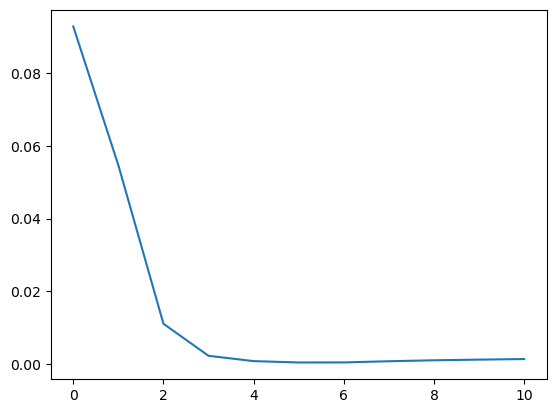

In [10]:
model_baseline = MLP(nep_x.shape[1])

train(model=model_baseline, x=nep_x, dx=nep_dx, batch_size=32, epochs=20, baseline=True, lr=1e-3)


# HNN

In [12]:
def HNN(x, model):
    H = model(x)

    # this is where the HNN magic happens!!
    x_field = torch.autograd.grad(H.sum(), x, create_graph=True, retain_graph=True)[0] # gradients for field
    dH = torch.zeros_like(x_field)

    # Hamiltonian equations
    # dq = dH/dp
    dH.T[0] = x_field.T[1]
  
    # dp = -dH/dq
    dH.T[1] = -x_field.T[0]

    return dH

100%|██████████| 51/51 [00:07<00:00,  6.53it/s]


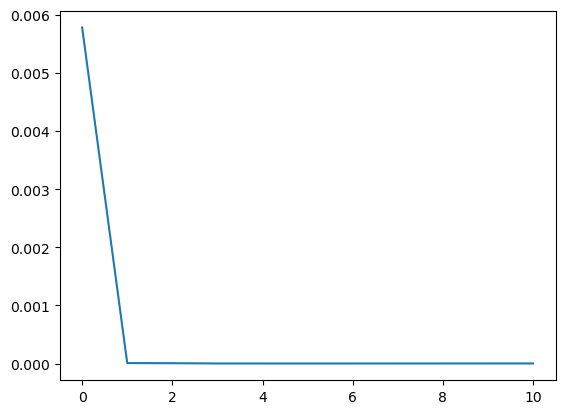

In [13]:
model_HNN = MLP(nep_x.shape[1])

train(model=model_HNN, x=nep_x, dx=nep_dx, batch_size=32, epochs=50, baseline=False, lr=1e-3)

# Predicting

In [14]:
q_p0 = nep_x[0].detach().numpy()
t_span = [0, 1000]
steps = 10000

# integrate
t = torch.linspace(t_span[0], t_span[1], steps)
xHNN = integrate_model(model_HNN.double(), t_span=t_span, y0=q_p0, t_eval=t, baseline=False)
xBaseline = integrate_model(model_baseline.double(), t_span=t_span, y0=q_p0, t_eval=t, baseline=True)

/Users/bguenes/Documents/Uni/Master/WiSe 23:24/Scientific ML/Scientific_ML_seminar/functions.py:74: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_11601pzv9m/croot/pytorch_1681837278807/work/aten/src/ATen/native/TensorShape.cpp:3281.)
  dH.T[0] = x_field.T[3]


IndexError: index 3 is out of bounds for dimension 0 with size 2

In [ ]:
HNN_data = reshape_data(xHNN.y)
Baseline_data = reshape_data(xBaseline.y)

# Plot the results
## HNN

## Baseline NN

# Plot Hamiltonian